## An Exploration of the Predictive Power of Social News Sentiment on Stock Market Prices

In [225]:
# importing various libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from keras.layers import SimpleRNN
from keras.utils import np_utils
from tensorflow.keras.metrics import Precision, Recall

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Preparation

In [226]:
# reading in the date csv files shared between VM and local machine
date_1 = pd.read_csv("date_1.csv")
date_2 = pd.read_csv("date_2.csv")
date_3 = pd.read_csv("date_3.csv")
date_4 = pd.read_csv("date_4.csv")
date_5 = pd.read_csv("date_5.csv")

full_date_df = pd.concat([date_1,date_2,date_3,date_4,date_5])

In [227]:
full_date_df.head()

,created_utc
0,1201236548
1,1201236599
2,1201236626
3,1201236662
4,1201236696


In [228]:
# reading in the reddit thread title files shared between VM and local machine
title_1 = pd.read_csv("title_1.csv")
title_2 = pd.read_csv("title_2.csv")
title_3 = pd.read_csv("title_3.csv")
title_4 = pd.read_csv("title_4.csv")
title_5 = pd.read_csv("title_5.csv")

full_title_df = pd.concat([title_1,title_2,title_3,title_4,title_5])

In [229]:
full_title_df.head()

,title
0,The Best Economics Blog Going
1,Meta: Seed The Economics blog with direct link...
2,Meta: Seed The Economics subreddit with direct...
3,Calculated Risk
4,Chris Blattman's Blog


In [230]:
# combining the date and titles dataframes
full_df = pd.concat([full_date_df.reset_index(), full_title_df.reset_index()], axis=1)

In [231]:
# removing NA values
full_df_clean = full_df.dropna()

In [232]:
print(full_df_clean.shape)

(263650, 4)


In [233]:
full_df_clean.head()

,index,created_utc,index,title
0,0.0,1.201237e+09,0,The Best Economics Blog Going
1,1.0,1.201237e+09,1,Meta: Seed The Economics blog with direct link...
2,2.0,1.201237e+09,2,Meta: Seed The Economics subreddit with direct...
3,3.0,1.201237e+09,3,Calculated Risk
4,4.0,1.201237e+09,4,Chris Blattman's Blog


In [234]:
# removing the index column
full_df_clean = full_df_clean[['created_utc','title']]

In [235]:
# transforming the UTC timestamp to a datetime object
full_df_clean['date'] = pd.to_datetime(full_df_clean['created_utc'], unit = "s")
full_df_clean.head()

,created_utc,title,date
0,1.201237e+09,The Best Economics Blog Going,2008-01-25 04:49:08
1,1.201237e+09,Meta: Seed The Economics blog with direct link...,2008-01-25 04:49:59
2,1.201237e+09,Meta: Seed The Economics subreddit with direct...,2008-01-25 04:50:26
3,1.201237e+09,Calculated Risk,2008-01-25 04:51:02
4,1.201237e+09,Chris Blattman's Blog,2008-01-25 04:51:36


In [236]:
# removing the time component
full_df_clean['date'] = full_df_clean['date'].dt.date
full_df_clean.head()

,created_utc,title,date
0,1.201237e+09,The Best Economics Blog Going,2008-01-25
1,1.201237e+09,Meta: Seed The Economics blog with direct link...,2008-01-25
2,1.201237e+09,Meta: Seed The Economics subreddit with direct...,2008-01-25
3,1.201237e+09,Calculated Risk,2008-01-25
4,1.201237e+09,Chris Blattman's Blog,2008-01-25


In [237]:
full_df_clean = full_df_clean[['date', 'title']]
full_df_clean.head()

,date,title
0,2008-01-25,The Best Economics Blog Going
1,2008-01-25,Meta: Seed The Economics blog with direct link...
2,2008-01-25,Meta: Seed The Economics subreddit with direct...
3,2008-01-25,Calculated Risk
4,2008-01-25,Chris Blattman's Blog


In [238]:
# vader word analyser
analyzer = SentimentIntensityAnalyzer()

In [239]:
# loop through the titles and assigning raw VADER scores
scores = []
for i in range(0,len(full_df_clean['title'])):
    row_index = i
    text_to_analyse = full_df_clean.loc[row_index,'title']
    sentiment_scores = analyzer.polarity_scores(text_to_analyse)
    compound_score = sentiment_scores['compound']
    scores.append(compound_score)

In [240]:
len(scores)

263650

In [241]:
full_df_clean['scores'] = scores
full_df_clean.head()

,date,title,scores
0,2008-01-25,The Best Economics Blog Going,0.6369
1,2008-01-25,Meta: Seed The Economics blog with direct link...,0.4588
2,2008-01-25,Meta: Seed The Economics subreddit with direct...,0.4588
3,2008-01-25,Calculated Risk,-0.2732
4,2008-01-25,Chris Blattman's Blog,0.0000


In [242]:
full_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263650 entries, 0 to 263649
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    263650 non-null  object 
 1   title   263650 non-null  object 
 2   scores  263650 non-null  float64
dtypes: float64(1), object(2)
memory usage: 18.0+ MB


In [243]:
full_df_clean['date'] = pd.to_datetime(full_df_clean['date'])

In [244]:
full_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263650 entries, 0 to 263649
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    263650 non-null  datetime64[ns]
 1   title   263650 non-null  object        
 2   scores  263650 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 18.0+ MB


In [245]:
full_df_clean.head()

,date,title,scores
0,2008-01-25,The Best Economics Blog Going,0.6369
1,2008-01-25,Meta: Seed The Economics blog with direct link...,0.4588
2,2008-01-25,Meta: Seed The Economics subreddit with direct...,0.4588
3,2008-01-25,Calculated Risk,-0.2732
4,2008-01-25,Chris Blattman's Blog,0.0000


In [246]:
# aggregating the scores for each date in the dataset by computing the average
sentiment_df = full_df_clean.groupby('date')['scores'].mean().reset_index()

In [247]:
sentiment_df.head()

,date,scores
0,2008-01-25,0.084243
1,2008-01-26,0.003900
2,2008-01-27,0.075342
3,2008-01-28,-0.027604
4,2008-01-29,0.030093


In [248]:
sentiment_df.tail()

,date,scores
4751,2022-12-27,0.083791
4752,2022-12-28,-0.019761
4753,2022-12-29,0.011074
4754,2022-12-30,0.020986
4755,2022-12-31,-0.193041


In [249]:
# classifying the scores into three different groups
for i in range(0,len(sentiment_df['scores'])):
    if sentiment_df.loc[i,'scores'] >= 0.05:
        sentiment_df.loc[i,'sentiment'] = 'Positive'
    elif sentiment_df.loc[i,'scores'] <= -0.05:
        sentiment_df.loc[i,'sentiment'] = 'Negative'
    else:
        sentiment_df.loc[i,'sentiment'] = 'Neutral'

In [250]:
sentiment_df.head()

,date,scores,sentiment
0,2008-01-25,0.084243,Positive
1,2008-01-26,0.003900,Neutral
2,2008-01-27,0.075342,Positive
3,2008-01-28,-0.027604,Neutral
4,2008-01-29,0.030093,Neutral


In [251]:
# reading in the S&P 500 index closing prices
sp_500 = pd.read_excel("SP_500_prices.xlsx")
sp_500.head()

,Dates,PX_LAST
0,2008-01-25,1330.61
1,2008-01-28,1353.97
2,2008-01-29,1362.30
3,2008-01-30,1355.81
4,2008-01-31,1378.55


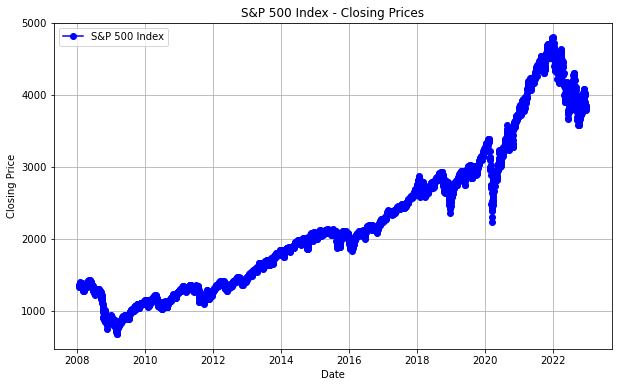

In [252]:
# using matplotlib.pyplot to create a plot of the index for the dates 
plt.figure(figsize=(10,6))
plt.plot(sp_500['Dates'], sp_500['PX_LAST'], marker = 'o', color = 'b', label = 'S&P 500 Index')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('S&P 500 Index - Closing Prices')
plt.legend()
plt.grid(True)
plt.show()

In [253]:
# joining the price data onto the sentiment dataset
sp_sentiment = pd.merge(sp_500, sentiment_df, left_on = "Dates", right_on = "date", how = "left")
sp_sentiment.head()

,Dates,PX_LAST,date,scores,sentiment
0,2008-01-25,1330.61,2008-01-25,0.084243,Positive
1,2008-01-28,1353.97,2008-01-28,-0.027604,Neutral
2,2008-01-29,1362.30,2008-01-29,0.030093,Neutral
3,2008-01-30,1355.81,2008-01-30,-0.115100,Negative
4,2008-01-31,1378.55,2008-01-31,-0.014772,Neutral


In [254]:
# classifying upward and downward movement in the index price
for i in range(0,len(sp_sentiment.scores) - 1):
    if sp_sentiment.loc[i+1,'PX_LAST'] > sp_sentiment.loc[i,'PX_LAST']:
        sp_sentiment.loc[i+1,'Direction'] = 'Up'
    else:
        sp_sentiment.loc[i+1,'Direction'] = 'Down'

In [255]:
sp_sentiment.head()

,Dates,PX_LAST,date,scores,sentiment,Direction
0,2008-01-25,1330.61,2008-01-25,0.084243,Positive,NaN
1,2008-01-28,1353.97,2008-01-28,-0.027604,Neutral,Up
2,2008-01-29,1362.30,2008-01-29,0.030093,Neutral,Up
3,2008-01-30,1355.81,2008-01-30,-0.115100,Negative,Down
4,2008-01-31,1378.55,2008-01-31,-0.014772,Neutral,Up


In [256]:
sp_sentiment.tail()

,Dates,PX_LAST,date,scores,sentiment,Direction
3756,2022-12-23,3844.82,2022-12-23,-0.131208,Negative,Up
3757,2022-12-27,3829.25,2022-12-27,0.083791,Positive,Down
3758,2022-12-28,3783.22,2022-12-28,-0.019761,Neutral,Down
3759,2022-12-29,3849.28,2022-12-29,0.011074,Neutral,Up
3760,2022-12-30,3839.50,2022-12-30,0.020986,Neutral,Down


In [257]:
# matching the sentiment of a particular day 
sp_sentiment['sentiment_lead'] = sp_sentiment['sentiment'].shift(periods=1, fill_value=None)

In [258]:
sp_sentiment.head()

,Dates,PX_LAST,date,scores,sentiment,Direction,sentiment_lead
0,2008-01-25,1330.61,2008-01-25,0.084243,Positive,NaN,NaN
1,2008-01-28,1353.97,2008-01-28,-0.027604,Neutral,Up,Positive
2,2008-01-29,1362.30,2008-01-29,0.030093,Neutral,Up,Neutral
3,2008-01-30,1355.81,2008-01-30,-0.115100,Negative,Down,Neutral
4,2008-01-31,1378.55,2008-01-31,-0.014772,Neutral,Up,Negative


In [259]:
sp_sent_df_clean = sp_sentiment.dropna()
sp_sent_df_clean.head()

,Dates,PX_LAST,date,scores,sentiment,Direction,sentiment_lead
1,2008-01-28,1353.97,2008-01-28,-0.027604,Neutral,Up,Positive
2,2008-01-29,1362.30,2008-01-29,0.030093,Neutral,Up,Neutral
3,2008-01-30,1355.81,2008-01-30,-0.115100,Negative,Down,Neutral
4,2008-01-31,1378.55,2008-01-31,-0.014772,Neutral,Up,Negative
5,2008-02-01,1395.42,2008-02-01,-0.237369,Negative,Up,Neutral


In [260]:
sp_sent_df_clean.head()

,Dates,PX_LAST,date,scores,sentiment,Direction,sentiment_lead
1,2008-01-28,1353.97,2008-01-28,-0.027604,Neutral,Up,Positive
2,2008-01-29,1362.30,2008-01-29,0.030093,Neutral,Up,Neutral
3,2008-01-30,1355.81,2008-01-30,-0.115100,Negative,Down,Neutral
4,2008-01-31,1378.55,2008-01-31,-0.014772,Neutral,Up,Negative
5,2008-02-01,1395.42,2008-02-01,-0.237369,Negative,Up,Neutral


In [261]:
# lagging the direction to include as a feature for neural network
sp_sent_df_clean['Direction_lag'] = sp_sent_df_clean['Direction'].shift(periods=-1, fill_value=None)
sp_sent_df_clean.head()

<ipython-input-261-cbe22c7359af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_sent_df_clean['Direction_lag'] = sp_sent_df_clean['Direction'].shift(periods=-1, fill_value=None)


,Dates,PX_LAST,date,scores,sentiment,Direction,sentiment_lead,Direction_lag
1,2008-01-28,1353.97,2008-01-28,-0.027604,Neutral,Up,Positive,Up
2,2008-01-29,1362.30,2008-01-29,0.030093,Neutral,Up,Neutral,Down
3,2008-01-30,1355.81,2008-01-30,-0.115100,Negative,Down,Neutral,Up
4,2008-01-31,1378.55,2008-01-31,-0.014772,Neutral,Up,Negative,Up
5,2008-02-01,1395.42,2008-02-01,-0.237369,Negative,Up,Neutral,Down


In [262]:
sp_sent_df_clean = sp_sent_df_clean.reset_index()
sp_sent_df_clean.head()

,index,Dates,PX_LAST,date,scores,sentiment,Direction,sentiment_lead,Direction_lag
0,1,2008-01-28,1353.97,2008-01-28,-0.027604,Neutral,Up,Positive,Up
1,2,2008-01-29,1362.30,2008-01-29,0.030093,Neutral,Up,Neutral,Down
2,3,2008-01-30,1355.81,2008-01-30,-0.115100,Negative,Down,Neutral,Up
3,4,2008-01-31,1378.55,2008-01-31,-0.014772,Neutral,Up,Negative,Up
4,5,2008-02-01,1395.42,2008-02-01,-0.237369,Negative,Up,Neutral,Down


In [263]:
# encoding the variable sentiment_lag
sentiment_lag = []

for i in range(0,len(sp_sent_df_clean.scores)):
    if sp_sent_df_clean.loc[i,'sentiment'] == 'Negative':
        sentiment_lag.append(0)
    elif sp_sent_df_clean.loc[i,'sentiment'] == 'Neutral':
        sentiment_lag.append(1)
    elif sp_sent_df_clean.loc[i,'sentiment'] == 'Positive':
        sentiment_lag.append(2)

In [264]:
# encoding the variable sentiment_lead
sentiment_lead = []

for i in range(0,len(sp_sent_df_clean.scores)):
    if sp_sent_df_clean.loc[i,'sentiment_lead'] == 'Negative':
        sentiment_lead.append(0)
    elif sp_sent_df_clean.loc[i,'sentiment_lead'] == 'Neutral':
        sentiment_lead.append(1)
    elif sp_sent_df_clean.loc[i,'sentiment_lead'] == 'Positive':
        sentiment_lead.append(2)

In [265]:
# encoding the variable direction
direction = []

for i in range(0,len(sp_sent_df_clean.scores)):
    if sp_sent_df_clean.loc[i,'Direction'] == 'Up':
        direction.append(1)
    else:
        direction.append(0)

In [266]:
# encoding the variable direction_lag
direction_lag = []

for i in range(0,len(sp_sent_df_clean.scores)):
    if sp_sent_df_clean.loc[i,'Direction_lag'] == 'Up':
        direction_lag.append(1)
    else:
        direction_lag.append(0)

In [267]:
# creating a dataset
data = {'date': sp_sent_df_clean.Dates, 'sentiment_lag': sentiment_lag, 'sentiment_lead': sentiment_lead, 
        'direction_lag': direction_lag, 'direction': direction}
df = pd.DataFrame(data)
df.head()

,date,sentiment_lag,sentiment_lead,direction_lag,direction
0,2008-01-28,1,2,1,1
1,2008-01-29,1,1,0,1
2,2008-01-30,0,1,1,0
3,2008-01-31,1,0,1,1
4,2008-02-01,0,1,0,1


## Modelling

In [268]:
X = np.array(df[['sentiment_lag', 'sentiment_lead', 'direction_lag']])
y = np.array(df.direction)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [270]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### ANN

In [271]:
# defining a function for the creation of an ANN to be used for hyperparamter tuning
def create_model(optimizer='adam', hidden_units=12,activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_dim=3))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall()])
    return model

In [272]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

<ipython-input-272-8dc1a02b4106>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)


In [273]:
# the grid to tune relevant hyperparameters
param_grid = {
    'batch_size': [10, 20],
    'epochs': [10,20],
    'hidden_units': [8, 12, 24],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

In [274]:
# cross-validation grid search for the grid previously defined
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [275]:
# perform the grid search
grid_result = grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [276]:
# get the best hyperparameters
best_params = grid_result.best_params_
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'hidden_units': 8, 'optimizer': 'rmsprop'}


In [277]:
# obtains the best model from the grid search and computes the accuracy on the test data
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')

31/31 [==============================] - 0s 4ms/step
Accuracy on Test Set: 53.66%


In [278]:
precision = precision_score(y_test, y_pred)
print(f'Precision on Test Set: {precision * 100:.2f}%')

Precision on Test Set: 53.66%


In [279]:
recall = recall_score(y_test, y_pred)
print(f'Recall on Test Set: {recall * 100:.2f}%')

Recall on Test Set: 100.00%


In [280]:
# the architecture of the best model
model = Sequential()
model.add(Dense(24, input_dim=3, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics = ['accuracy', Precision(), Recall()])

In [281]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=20) 

Epoch 1/10
115/115 [==============================] - 3s 5ms/step - loss: 0.6961 - accuracy: 0.5390 - precision_1: 0.5443 - recall_1: 0.9657
Epoch 2/10
115/115 [==============================] - 1s 5ms/step - loss: 0.6929 - accuracy: 0.5412 - precision_1: 0.5464 - recall_1: 0.9490
Epoch 3/10
115/115 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.5338 - precision_1: 0.5451 - recall_1: 0.8915
Epoch 4/10
115/115 [==============================] - 1s 5ms/step - loss: 0.6922 - accuracy: 0.5294 - precision_1: 0.5414 - recall_1: 0.9131
Epoch 5/10
115/115 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.5351 - precision_1: 0.5433 - recall_1: 0.9402
Epoch 6/10
115/115 [==============================] - 1s 5ms/step - loss: 0.6914 - accuracy: 0.5438 - precision_1: 0.5460 - recall_1: 0.9841
Epoch 7/10
115/115 [==============================] - 1s 5ms/step - loss: 0.6911 - accuracy: 0.5464 - precision_1: 0.5470 - recall_1: 0.9928
Epoch 8/10
11

In [282]:
# training accuracy
_, accuracy, precision, recall = model.evaluate(X_train_scaled, y_train)
print('Accuracy: %.2f' % (accuracy*100), 'Precision: %.2f' % (precision*100), 'Recall: %.2f' % (recall*100)) 

72/72 [==============================] - 1s 5ms/step - loss: 0.6898 - accuracy: 0.5469 - precision_1: 0.5469 - recall_1: 1.0000
Accuracy: 54.69 Precision: 54.69 Recall: 100.00


### RNN

In [283]:
X = np.array(df[['sentiment_lag', 'sentiment_lead', 'direction_lag']])
y = np.array(df.direction)

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [285]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [286]:
# rehsaping the training data to allow for RNN fit
X_r_train = X_train_scaled.reshape(-1,3,1)
X_r_train

array([[[ 0.23907182],
        [ 0.21456481],
        [ 0.92557018]],

       [[-1.35915467],
        [ 0.21456481],
        [ 0.92557018]],

       [[ 0.23907182],
        [ 0.21456481],
        [ 0.92557018]],

       ...,

       [[ 0.23907182],
        [ 0.21456481],
        [ 0.92557018]],

       [[ 0.23907182],
        [ 1.81195806],
        [ 0.92557018]],

       [[-1.35915467],
        [-1.38282843],
        [ 0.92557018]]])

In [287]:
# refitting test data
X_r_test = X_test_scaled.reshape(-1,3,1)
X_r_test

array([[[ 0.23907182],
        [ 0.21456481],
        [ 0.92557018]],

       [[-1.35915467],
        [-1.38282843],
        [ 0.92557018]],

       [[ 1.83729831],
        [ 0.21456481],
        [-1.0804151 ]],

       ...,

       [[ 0.23907182],
        [ 0.21456481],
        [ 0.92557018]],

       [[ 0.23907182],
        [ 0.21456481],
        [-1.0804151 ]],

       [[ 0.23907182],
        [ 0.21456481],
        [ 0.92557018]]])

In [288]:
# defining a function to allow for model build for gridsearch hyperparameter tuning
def create_rnn_model(units=50, optimizer = 'adam', activation = 'relu'):
    model = Sequential()
    model.add(SimpleRNN(units, activation = activation, input_shape=(X_r_train.shape[1], X_r_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy', Precision(), Recall()])
    return model

In [289]:
rnn_model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_rnn_model, verbose=0)

<ipython-input-289-3a4eae250d27>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_rnn_model, verbose=0)


In [290]:
param_grid = {
    'units': [50,100],
    'epochs': [10,20],
    'batch_size': [10, 20],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

In [291]:
grid_search = GridSearchCV(estimator=rnn_model, param_grid=param_grid, cv=3, n_jobs=1, verbose=2)

In [292]:
grid_result_rnn = grid_search.fit(X_r_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=adam, units=50; total time=  11.7s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=adam, units=50; total time=  11.8s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=adam, units=50; total time=  11.7s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=adam, units=100; total time=  12.2s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=adam, units=100; total time=  11.8s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=adam, units=100; total time=  12.4s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=sgd, units=50; total time=  11.8s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=sgd, units=50; total time=  10.8s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=sgd, units=50; total time=  10.3s
[CV] END activation=relu, batch_size=10, epochs=10, optimizer=sgd

[CV] END activation=sigmoid, batch_size=10, epochs=10, optimizer=sgd, units=100; total time=  11.3s
[CV] END activation=sigmoid, batch_size=10, epochs=10, optimizer=rmsprop, units=50; total time=  10.6s
[CV] END activation=sigmoid, batch_size=10, epochs=10, optimizer=rmsprop, units=50; total time=  10.9s
[CV] END activation=sigmoid, batch_size=10, epochs=10, optimizer=rmsprop, units=50; total time=  11.1s
[CV] END activation=sigmoid, batch_size=10, epochs=10, optimizer=rmsprop, units=100; total time=  11.3s
[CV] END activation=sigmoid, batch_size=10, epochs=10, optimizer=rmsprop, units=100; total time=  11.7s
[CV] END activation=sigmoid, batch_size=10, epochs=10, optimizer=rmsprop, units=100; total time=  11.4s
[CV] END activation=sigmoid, batch_size=10, epochs=20, optimizer=adam, units=50; total time=  19.2s
[CV] END activation=sigmoid, batch_size=10, epochs=20, optimizer=adam, units=50; total time=  17.9s
[CV] END activation=sigmoid, batch_size=10, epochs=20, optimizer=adam, units=50

In [293]:
best_params = grid_result_rnn.best_params_
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'activation': 'relu', 'batch_size': 20, 'epochs': 10, 'optimizer': 'sgd', 'units': 100}


In [294]:
best_model = grid_result_rnn.best_estimator_
y_pred = best_model.predict(X_r_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')

31/31 [==============================] - 1s 5ms/step
Accuracy on Test Set: 51.32%


In [295]:
precision = precision_score(y_test, y_pred)
print(f'Precision on Test Set: {precision * 100:.2f}%')

Precision on Test Set: 51.32%


In [296]:
recall = recall_score(y_test, y_pred)
print(f'Recall on Test Set: {recall * 100:.2f}%')

Recall on Test Set: 100.00%


In [300]:
model = Sequential()
model.add(SimpleRNN(100, activation = 'relu', input_shape=(X_r_train.shape[1], X_r_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'sgd', metrics=['accuracy', Precision(), Recall()])

In [301]:
model.fit(X_r_train, y_train, epochs=10, batch_size=20) 

Epoch 1/10
115/115 [==============================] - 4s 8ms/step - loss: 0.6966 - accuracy: 0.4697 - precision_148: 0.5301 - recall_148: 0.4205
Epoch 2/10
115/115 [==============================] - 1s 8ms/step - loss: 0.6884 - accuracy: 0.5543 - precision_148: 0.5563 - recall_148: 0.9867
Epoch 3/10
115/115 [==============================] - 1s 7ms/step - loss: 0.6871 - accuracy: 0.5569 - precision_148: 0.5569 - recall_148: 1.0000
Epoch 4/10
115/115 [==============================] - 1s 7ms/step - loss: 0.6866 - accuracy: 0.5569 - precision_148: 0.5569 - recall_148: 1.0000
Epoch 5/10
115/115 [==============================] - 1s 7ms/step - loss: 0.6864 - accuracy: 0.5569 - precision_148: 0.5569 - recall_148: 1.0000
Epoch 6/10
115/115 [==============================] - 1s 8ms/step - loss: 0.6861 - accuracy: 0.5569 - precision_148: 0.5569 - recall_148: 1.0000
Epoch 7/10
115/115 [==============================] - 1s 7ms/step - loss: 0.6859 - accuracy: 0.5569 - precision_148: 0.5569 - reca

In [302]:
_, accuracy, precision, recall = model.evaluate(X_r_train, y_train)
print('Accuracy: %.2f' % (accuracy*100), 'Precision: %.2f' % (precision*100), 'Recall: %.2f' % (recall*100)) 

72/72 [==============================] - 1s 6ms/step - loss: 0.6850 - accuracy: 0.5569 - precision_148: 0.5569 - recall_148: 1.0000
Accuracy: 55.69 Precision: 55.69 Recall: 100.00
